# Models

## Table of Contents
- Load Data
- Sample and Feature Preparation
    - Missing RFM Segment
    - Train-Eval-Test Split
    - Missing Data
    - One-Hot Encoding
    - Label Encoding
    - Output Encoding
- Utils
- Model Selection
    - RandomForest
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
    - LightGBM
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
- Final Model
    - Final Model
    - Metrics
    - Model Analysis
    - Feature Importance

In [1]:
from typing import Tuple, Any

import pickle as pkl
import joblib
from copy import deepcopy
from itertools import combinations
import random
from math import factorial
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# utils
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

# models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
) 
import shap

In [2]:
# sns config
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

In [3]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

**Note:**
- Keep only features that have predictive value based on Data Analysis.
- Keep only features that are present during inference time, e.g. loan statistics are discarded since these are present after the loan has been settled.

In [4]:
ftrs = ['id', 'user_id', 'created_at', 'principal_amount_cat', 'interest_rate_cat', 'loan_quality']

df_loans = pd.read_pickle("../data/processed/df_loans.pkl")
df_loans = df_loans[ftrs]

df_loans

,id,user_id,created_at,principal_amount_cat,interest_rate_cat,loan_quality
3,3,2585,2022-02-01,large,small,low_quality
5,5,806,2022-02-01,large,small,low_quality
6,6,1920,2022-02-01,large,small,low_quality
13,13,2323,2022-02-01,large,small,low_quality
14,14,1838,2022-02-01,large,small,low_quality
...,...,...,...,...,...,...
5042,6740,1315,2022-10-03,large,large,high_quality
5043,6741,2130,2022-10-03,small,large,high_quality
5044,6742,549,2022-10-03,large,large,high_quality
5045,6743,1414,2022-10-03,large,large,high_quality


In [5]:
ftrs = ['user_id', 'rfm_segment_desc', 'avg_intallments', 'rate_denied', 'preference_installment', 'preference_credit', 'preference_purchase_online']

df_user_purchasing_behavior = pd.read_pickle("../data/processed/df_user_purchasing_behavior.pkl")
df_user_purchasing_behavior = df_user_purchasing_behavior[ftrs]
df_user_purchasing_behavior["preference_installment"] = df_user_purchasing_behavior["preference_installment"].astype(float)

df_user_purchasing_behavior

,user_id,rfm_segment_desc,avg_intallments,rate_denied,preference_installment,preference_credit,preference_purchase_online
0,1,Inactive,4.500000,0.300000,0.700000,5.000000,0.000000
1,2,Inactive,8.257143,0.057143,0.971429,17.500000,0.000000
2,3,Inactive,5.551282,0.115385,1.000000,79.000000,0.012821
3,4,Promising,2.646853,0.090909,0.419580,1.666667,0.003497
4,5,Promising,1.952081,0.083228,0.480454,131.500000,0.000000
...,...,...,...,...,...,...,...
3038,3149,Inactive,1.935065,0.069264,0.333333,2.065789,0.004329
3039,3150,Champions,1.618375,0.174323,0.398115,2.590717,0.289833
3040,3151,Inactive,2.687225,0.092511,0.568282,2.271429,0.017857
3041,3152,Promising,3.213775,0.135063,0.952594,61.222222,0.028493


In [6]:
ftrs = ['id', 'user_id', 'created_at', 'user_num_loans', 'user_pct_loans_small', 'user_pct_loans_medium', 'user_pct_loans_large',
        'user_pct_int_rate_small', 'user_pct_int_rate_medium', 'user_pct_int_rate_large', 'user_ratio_unpaid_loans',
        'user_avg_pct_debt', 'user_avg_num_repayments', 'user_avg_repayment_amount', 'user_avg_rate_default', 
        'user_rate_due_date_exceeded', 'user_avg_max_repayment_delay', 'user_avg_rate_manual_repayments']

df_user_repayment_history = pd.read_pickle("../data/processed/df_user_repayment_history.pkl")
df_user_repayment_history = df_user_repayment_history[ftrs]

# shift the information per user by one since at timestamp t only the behavior at timestamp t-1 is available
for ftr in ftrs:
    if ftr not in ['id', 'user_id', 'created_at',]:
        df_user_repayment_history[ftr] = df_user_repayment_history.groupby(["user_id"], as_index=False)[ftr].shift()

df_user_repayment_history

,id,user_id,created_at,user_num_loans,user_pct_loans_small,user_pct_loans_medium,user_pct_loans_large,user_pct_int_rate_small,user_pct_int_rate_medium,user_pct_int_rate_large,user_ratio_unpaid_loans,user_avg_pct_debt,user_avg_num_repayments,user_avg_repayment_amount,user_avg_rate_default,user_rate_due_date_exceeded,user_avg_max_repayment_delay,user_avg_rate_manual_repayments
81,86,1,2022-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,223,2,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1677,1744,3,2022-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,3984,4,2022-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5683,5824,4,2022-08-26,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,26.0,285.000000,0.038462,0.000000,0.0,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,1186,3153,2022-03-15,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,20.0,307.000000,0.000000,0.000000,0.0,0.047619
3017,3111,3153,2022-05-04,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,25.0,270.000000,0.017241,0.500000,110.0,0.077381
3752,3856,3153,2022-06-15,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,21.0,360.333333,0.035304,0.333333,74.0,0.128510
4247,4358,3153,2022-07-04,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,19.0,404.500000,0.026478,0.250000,55.0,0.134844


In [7]:
df_data = df_loans.merge(df_user_purchasing_behavior, how="left", on="user_id")
df_data = df_data.merge(df_user_repayment_history, how="left", on=["id", "user_id", "created_at"])

# sort by user_id and loan_created_at (ascending)
df_data = df_data.sort_values(by=["user_id", "created_at"])

# Sample and Feature Preparation

- Missing RFM Segment
- Train-Eval-Test Split
- Missing Data
- One-Hot Encoding
- Output Encoding

## Missing RFM Segment

**Note:** New users for which we don't have yet the transaction history, are assigned to the RFM customer segment `Recent`.

In [8]:
# new users for which we don't have yet the transaction history, are assigned to the RFM customer segment Recent
df_data.loc[df_data["rfm_segment_desc"].isna(), "rfm_segment_desc"] = "Recent"

## Train-Eval-Test Split

**Note:** Spliting data into train and test subsets where each user belongs only to one set in order to avoid data leakage.

In [9]:
def trainset_testset_split(
    data: pd.DataFrame, 
    key_user: str, 
    key_target: str, 
    test_size: float,
    stratify: str,
    random_state: int,
) -> Tuple[Any, ...]:
    """Split dataframe into train and test subsets where each user belongs only to one set.
    
    Args:
        data:
            Input dataframes.
        key_user:
            User identifier column name.
        key_target:
            Target column name.
        test_size:
            Represents the proportion of the dataset to include in the test split (should be between 0.0 and 1.0).
        stratify:.
            Column to split the data in a stratified fashion
        random_state:
            Controls the shuffling applied to the data before applying the split. 
            Pass an int for reproducible output across multiple function calls.
        
    Returns:
        Train-test split of inputs.
    """
    # split users into train and test set (a user cannot belong to the same set)
    df_users = data[[key_user, stratify]].drop_duplicates(subset=[key_user])
    train_users, test_users = train_test_split(df_users, test_size=test_size, stratify=df_users[stratify], random_state=random_state)
    train_user_ids, test_user_ids = train_users[key_user].tolist(), test_users[key_user].tolist()
    
    train, test = data[data[key_user].isin(train_user_ids)], data[data[key_user].isin(test_user_ids)]

    X_train, X_test = train.loc[:, train.columns != key_target], test.loc[:, test.columns != key_target]
    y_train, y_test = train.loc[:, train.columns == key_target], test.loc[:, test.columns == key_target]

    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = trainset_testset_split(
    df_data, 
    key_user="user_id", 
    key_target="loan_quality", 
    test_size=.3, 
    stratify="rfm_segment_desc",
    random_state=42
)
X_train, X_eval, y_train, y_eval = trainset_testset_split(
    pd.concat([X_train, y_train], axis=1), 
    key_user="user_id", 
    key_target="loan_quality", 
    test_size=.2, 
    stratify="rfm_segment_desc",
    random_state=42
)

In [11]:
print(
    f"Train: number of loans: {X_train['id'].unique().shape[0]:,}\n"
    f"Eval: number of loans: {X_eval['id'].unique().shape[0]:,}\n"
    f"Test: number of loans: {X_test['id'].unique().shape[0]:,}"
)

Train: number of loans: 3,731
Eval: number of loans: 878
Test: number of loans: 1,979


In [12]:
good_loan, bad_loan = y_train[y_train["loan_quality"] == "high_quality"].shape[0], y_train[y_train["loan_quality"] == "low_quality"].shape[0]
print(f"Train:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

good_loan, bad_loan = y_eval[y_eval["loan_quality"] == "high_quality"].shape[0], y_eval[y_eval["loan_quality"] == "low_quality"].shape[0]
print(f"Eval:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

good_loan, bad_loan = y_test[y_test["loan_quality"] == "high_quality"].shape[0], y_test[y_test["loan_quality"] == "low_quality"].shape[0]
print(f"Test:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

Train:
	number of good loans: 2,660
	number of bad loans: 1,071
Eval:
	number of good loans: 606
	number of bad loans: 272
Test:
	number of good loans: 1,416
	number of bad loans: 563


In [13]:
print(
    f"Train: number of users: {X_train['user_id'].unique().shape[0]:,}\n"
    f"Eval: number of users: {X_eval['user_id'].unique().shape[0]:,}\n"
    f"Test: number of users: {X_test['user_id'].unique().shape[0]:,}"
)

Train: number of users: 1,705
Eval: number of users: 427
Test: number of users: 914


In [14]:
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_eval, y_eval = X_eval.reset_index(drop=True), y_eval.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

## Missing Data

**Note:**
- **New users w/o transaction history**
    - New users for which we don't have yet the transaction history, have been assigned to the RFM customer segment `Recent`.
    - Purchase behavior for new users is calculated according to the RFM segment `Recent`. 
- **Users w/ repayment history**
    - Repayment behavior for users who take a loan for the first time doesn't exist. Thus, the model will solely depend on the purchasing behavior.

In [15]:
ftrs = ["avg_intallments", "rate_denied", "preference_installment", "preference_credit", "preference_purchase_online"]

# purchase behavior for new users is calculated according to the RFM segment Recent
for ftr in ftrs:
    # feature values are calculated on the trainset to avoid data leakage
    median_segment_value = X_train[X_train["rfm_segment_desc"] == "Recent"][ftr].median()
    X_train.loc[X_train[ftr].isna(), ftr] = median_segment_value
    X_eval.loc[X_eval[ftr].isna(), ftr] = median_segment_value
    X_test.loc[X_test[ftr].isna(), ftr] = median_segment_value

In [16]:
ftrs = ['user_num_loans', 'user_pct_loans_small', 'user_pct_loans_medium', 'user_pct_loans_large',
        'user_pct_int_rate_small', 'user_pct_int_rate_medium', 'user_pct_int_rate_large', 'user_ratio_unpaid_loans',
        'user_avg_pct_debt', 'user_avg_num_repayments', 'user_avg_repayment_amount', 'user_avg_rate_default', 
        'user_rate_due_date_exceeded', 'user_avg_max_repayment_delay', 'user_avg_rate_manual_repayments']

segments = ['Inactive', 'Promising', 'Big Spenders', 'Champions', 'Recent']

# repayment behavior for users who take a loan for the first time doesn't exist
# the model will solely depend on the purchasing behavior.
for ftr in ftrs:
    for segment in segments:
        default_value = 0 if ftr != "user_avg_rate_manual_repayments" else 1
        
        X_train.loc[(X_train[ftr].isna()) & (X_train["rfm_segment_desc"] == segment), ftr] = default_value
        X_eval.loc[(X_eval[ftr].isna()) & (X_eval["rfm_segment_desc"] == segment), ftr] = default_value
        X_test.loc[(X_test[ftr].isna()) & (X_test["rfm_segment_desc"] == segment), ftr] = default_value

## One-Hot Encoding

In [17]:
X_train = pd.concat([X_train, pd.get_dummies(X_train["rfm_segment_desc"], prefix="segment")], axis=1)
X_train = X_train.drop(["rfm_segment_desc"], axis=1)

In [18]:
X_eval = pd.concat([X_eval, pd.get_dummies(X_eval["rfm_segment_desc"], prefix="segment")], axis=1)
X_eval = X_eval.drop(["rfm_segment_desc"], axis=1)

In [19]:
X_test = pd.concat([X_test, pd.get_dummies(X_test["rfm_segment_desc"], prefix="segment")], axis=1)
X_test = X_test.drop(["rfm_segment_desc"], axis=1)

## Label Encoding

In [20]:
mapping = {
    "small": 1,
    "medium": 2,
    "large": 3,
}
X_train["principal_amount_cat"] = X_train["principal_amount_cat"].replace(mapping)
X_train["interest_rate_cat"] = X_train["interest_rate_cat"].replace(mapping)

X_eval["principal_amount_cat"] = X_eval["principal_amount_cat"].replace(mapping)
X_eval["interest_rate_cat"] = X_eval["interest_rate_cat"].replace(mapping)

X_test["principal_amount_cat"] = X_test["principal_amount_cat"].replace(mapping)
X_test["interest_rate_cat"] = X_test["interest_rate_cat"].replace(mapping)

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\1009736989.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\1009736989.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\1009736989.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.

## Output Encoding

In [21]:
mapping = {
    "low_quality": 0,
    "high_quality": 1,
}
y_train["loan_quality"] = y_train["loan_quality"].replace(mapping)
y_train["loan_quality"] = y_train["loan_quality"].replace(mapping)

y_eval["loan_quality"] = y_eval["loan_quality"].replace(mapping)
y_eval["loan_quality"] = y_eval["loan_quality"].replace(mapping)

y_test["loan_quality"] = y_test["loan_quality"].replace(mapping)
y_test["loan_quality"] = y_test["loan_quality"].replace(mapping)

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\2860099101.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\2860099101.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\2860099101.py:11: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

# Utils

In [22]:
def corrected_std(differences, n_train, n_test):
    """ Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        corrected_std:
            Variance-corrected standard deviation of the set of differences.
    """
    kr = len(differences)  # number of times the model was evaluated
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

In [23]:
def compute_corrected_ttest(differences, df, n_train, n_test):
    """ Computes right-tailed paired t-test with corrected variance.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        df:
            Degrees of freedom.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        t_stat:
            Variance-corrected t-statistic.
        p_val:
            Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [24]:
def k_fold(X: pd.DataFrame, key_user: str, folds: int) -> list:
    """ K-Fold cross-validator for multiple time-series data.

    Provides train/test indices to split data in train/test sets, based on the time-series user id.
    The objective is for a time-series to belong only on the train/test set and not in both, so that there is no data leakage.
    
    Args:
        X:
            Training data.
        key_user:
            User id column of the multiple time-series.
        folds:
            Number of folds.
    
    Returns:
        List of indices to split data into training and test set, per fold.
    """
    user_ids = X[key_user].unique().tolist()
    random.shuffle(user_ids)

    fold_ids = np.array_split(user_ids, folds)

    cv = []
    for fold_i in range(folds):
        train_user_ids = fold_ids[fold_i].tolist()
        test_user_ids = []
        for fold_j in range(folds):
            if fold_j != fold_i:
                test_user_ids.extend(fold_ids[fold_j].tolist())
                
        train_indexes = X[X[key_user].isin(train_user_ids)].index.values
        test_indexes = X[X[key_user].isin(test_user_ids)].index.values
        cv.append((train_indexes, test_indexes))
        
    return cv

In [25]:
folds = 10

cv = k_fold(X_train, key_user="user_id", folds=10)

In [26]:
def log_results(search) -> None:
    """Logs computed metrics from hyper-parameter tuning.

    Metrics:
        - weighted F1-score
        - weighted Precision
        - weighted Recall
    
    Args:
        search:
            Hyper-parameter optimizer instance.
    """
    print(
        f'Best search train weighted F1-score: '
        f'{search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f} '
        f'(+/- {search.cv_results_["std_train_f1_weighted"][search.best_index_]:,.2f})'
    )
    print(
        f'Best search eval weighted F1-score: '
        f'{search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f} '
        f'(+/- {search.cv_results_["std_test_f1_weighted"][search.best_index_]:,.2f})\n'
    )
    
    print(
        f'Best search train weighted Precision: '
        f'{search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f} '
        f'(+/- {search.cv_results_["std_train_precision_weighted"][search.best_index_]:,.2f})'
    )
    print(
        f'Best search eval weighted Precision: '
        f'{search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f} '
        f'(+/- {search.cv_results_["std_test_precision_weighted"][search.best_index_]:.2f})\n'
    )
    
    print(
        f'Best search train weighted Recall: '
        f'{search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f} '
        f'(+/- {search.cv_results_["std_train_recall_weighted"][search.best_index_]:,.2f})'
    )
    print(
        f'Best search eval weighted Recall: '
        f'{search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f} '
        f'(+/- {search.cv_results_["std_test_recall_weighted"][search.best_index_]:,.2f})\n'
    )
    
    print(f'Best search parameters:\n{search.best_params_}')

In [27]:
# drop identifiers
X_train = X_train.drop(columns=["id", "user_id", "created_at"])
X_eval = X_eval.drop(columns=["id", "user_id", "created_at"])
X_test = X_test.drop(columns=["id", "user_id", "created_at"])

# Model Selection

In [28]:
labels = ["bad candidate", "good candidate"]

## Random Forest

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 450, max_depth: 5, class_weight: balanced

In [29]:
pipe = Pipeline([
    ('feature_selection', RFE(RandomForestClassifier(random_state=42), n_features_to_select=.8)),
    ('clf', RandomForestClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)) + [None],
    'clf__class_weight': ["balanced", "balanced_subsample"]
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train, np.ravel(y_train))

In [31]:
log_results(search)

Best search train weighted F1-score: 0.87 (+/- 0.01)
Best search eval weighted F1-score: 0.78 (+/- 0.01)

Best search train weighted Precision: 0.87 (+/- 0.01)
Best search eval weighted Precision: 0.78 (+/- 0.01)

Best search train weighted Recall: 0.87 (+/- 0.01)
Best search eval weighted Recall: 0.78 (+/- 0.01)

Best search parameters:
OrderedDict([('clf__class_weight', 'balanced'), ('clf__max_depth', 5), ('clf__n_estimators', 450)])


In [32]:
# features to keep based on RFE
ftrs = search.best_estimator_["feature_selection"].get_feature_names_out().tolist()

with open('../models/random_forest/features_rfe.pkl', 'wb') as f:
    pkl.dump(ftrs, f)

### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [33]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted
iter,,,,
balanced_5_450,"{'clf__class_weight': 'balanced', 'clf__max_de...",1,0.870970,0.776766
balanced_5_400,"{'clf__class_weight': 'balanced', 'clf__max_de...",2,0.870465,0.776738
balanced_5_500,"{'clf__class_weight': 'balanced', 'clf__max_de...",3,0.870789,0.776625


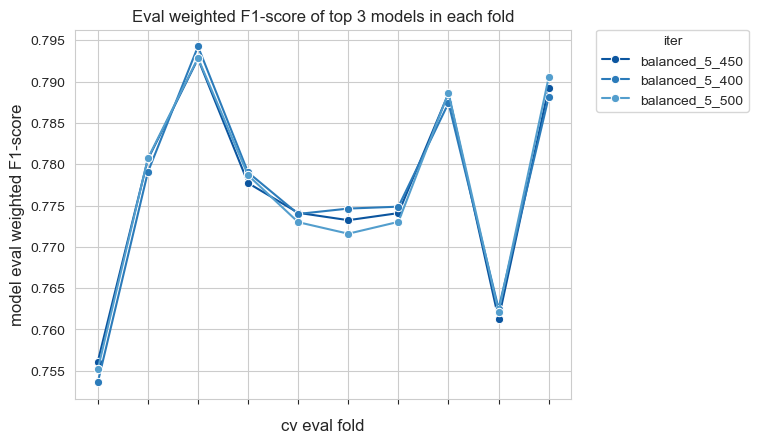

In [34]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [35]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,balanced_5_450,balanced_5_400,balanced_5_500
iter,,,
balanced_5_450,1.000000,0.992677,0.997035
balanced_5_400,0.992677,1.000000,0.989427
balanced_5_500,0.997035,0.989427,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that, although the models don't significantly differ from each other, the proposed model from hyperaparameter tuning is the recommended one.

In [36]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,balanced_5_450,balanced_5_400,0.006,1
1,balanced_5_450,balanced_5_500,0.046,1
2,balanced_5_400,balanced_5_500,0.021,1


### Final Model Evaluation

---

**Best model parameters:** n_estimators: 450, max_depth: 5, class_weight: balanced

---

**Conclusion:** 
- The model doesn't overfit.
- The model is certain when it encounters good candidates (85% Precision, 83% Recall), however, it struggles to identify bad candidates (68% Recall, 65% Precision). 

In [37]:
clf = RandomForestClassifier(
    n_estimators=450,
    max_depth=5,
    class_weight= 'balanced',
    random_state=42
)

clf.fit(X_train.loc[:, X_train.columns.isin(ftrs)], np.ravel(y_train))

y_train_pred = clf.predict(X_train.loc[:, X_train.columns.isin(ftrs)])
y_eval_pred = clf.predict(X_eval.loc[:, X_eval.columns.isin(ftrs)])

In [38]:
print(f"Train:\n{classification_report(y_train, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.64      0.71      0.67      1071
good candidate       0.88      0.84      0.86      2660

      accuracy                           0.80      3731
     macro avg       0.76      0.77      0.77      3731
  weighted avg       0.81      0.80      0.81      3731

Eval:
                precision    recall  f1-score   support

 bad candidate       0.65      0.68      0.67       272
good candidate       0.85      0.83      0.84       606

      accuracy                           0.79       878
     macro avg       0.75      0.76      0.76       878
  weighted avg       0.79      0.79      0.79       878



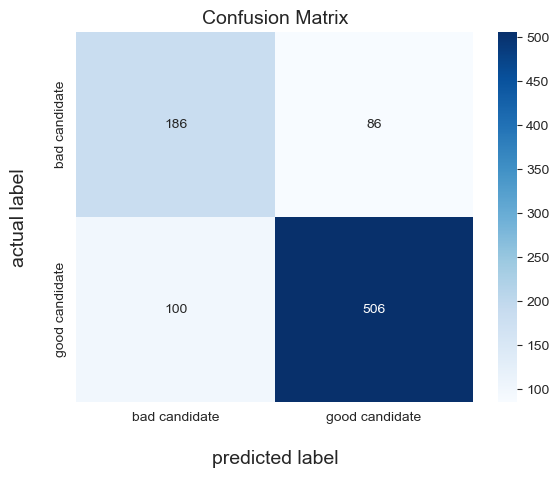

In [39]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## LightGBM

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 350, max_depth: 20, learning_rate: 0.001, colsample_bytree: 0.8, booster: gbdt, class_weight: balanced

In [40]:
pipe = Pipeline([
    ('feature_selection', RFE(RandomForestClassifier(random_state=42), n_features_to_select=.8)),
    ('clf', LGBMClassifier(class_weight="balanced", random_state=42, verbose=-1))
])

# hyperparameter space
parameters = {
    'clf__estimator__n_estimators': list(range(50, 550, 50)),
    'clf__estimator__max_depth': list(range(5, 55, 5)),
    'clf__estimator__colsample_bytree': [.4, .5, .6, .8, 1],
    'clf__estimator__learning_rate': [1, 1e-1, 1e-2, 1e-3],
    'clf__estimator__boosting_type': ['gbdt', 'dart']
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train, np.ravel(y_train))

In [42]:
log_results(search)

Best search train weighted F1-score: 0.98 (+/- 0.01)
Best search eval weighted F1-score: 0.74 (+/- 0.01)

Best search train weighted Precision: 0.98 (+/- 0.01)
Best search eval weighted Precision: 0.75 (+/- 0.01)

Best search train weighted Recall: 0.98 (+/- 0.01)
Best search eval weighted Recall: 0.73 (+/- 0.01)

Best search parameters:
OrderedDict([('clf__estimator__boosting_type', 'gbdt'), ('clf__estimator__colsample_bytree', 0.8), ('clf__estimator__learning_rate', 0.001), ('clf__estimator__max_depth', 20), ('clf__estimator__n_estimators', 350)])


In [43]:
# features to keep based on RFE
ftrs = search.best_estimator_["feature_selection"].get_feature_names_out().tolist()

with open('../models/lightgbm/features_rfe.pkl', 'wb') as f:
    pkl.dump(ftrs, f)

### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [44]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted",]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted
iter,,,,
gbdt_0.8_0.001_20_350,"{'clf__estimator__boosting_type': 'gbdt', 'clf...",1,0.982362,0.738059
dart_1_0.001_35_400,"{'clf__estimator__boosting_type': 'dart', 'clf...",1,0.982362,0.738059
dart_0.5_0.1_25_50,"{'clf__estimator__boosting_type': 'dart', 'clf...",1,0.982362,0.738059


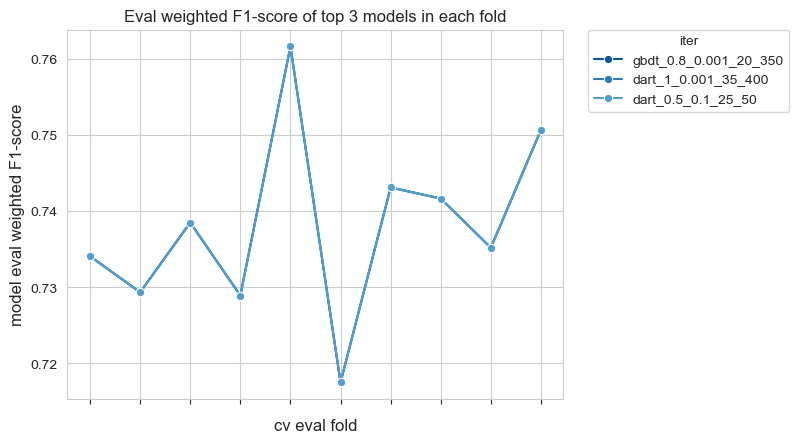

In [45]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [46]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,gbdt_0.8_0.001_20_350,dart_1_0.001_35_400,dart_0.5_0.1_25_50
iter,,,
gbdt_0.8_0.001_20_350,1.0,1.0,1.0
dart_1_0.001_35_400,1.0,1.0,1.0
dart_0.5_0.1_25_50,1.0,1.0,1.0


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models are **identical**, thus we can select the proposed model from hyperaparameter tuning.

In [47]:
# pairwise comparison of models based on weighted F1-score

n_train = len(cv[0][0])
n_test = len(cv[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

C:\Users\lampr\AppData\Local\Temp\ipykernel_10344\2293907000.py:22: RuntimeWarning:

invalid value encountered in scalar divide



,model_1,model_2,t_stat,p_val
0,gbdt_0.8_0.001_20_350,dart_1_0.001_35_400,NaN,NaN
1,gbdt_0.8_0.001_20_350,dart_0.5_0.1_25_50,NaN,NaN
2,dart_1_0.001_35_400,dart_0.5_0.1_25_50,NaN,NaN


### Final Model Evaluation

---

**Best model parameters:** n_estimators: 350, max_depth: 20, learning_rate: 0.001, colsample_bytree: 0.8, booster: gbdt, class_weight: balanced

---

**Conclusion:**
- The model doesn't overfit.
- The model is certain when it encounters good candidates (87% Precision, 81% Recall), however, it isn't confident when identifing bad candidates (63% Precision, 73% Recall). 

In [48]:
clf = LGBMClassifier(
    n_estimators=350,
    max_depth=20,
    learning_rate=0.001,
    colsample_bytree=0.8,
    boosting_type="gbdt",
    class_weight="balanced",
    random_state=42,
    verbose=-1
)

clf.fit(X_train.loc[:, X_train.columns.isin(ftrs)], np.ravel(y_train))

y_train_pred = clf.predict(X_train.loc[:, X_train.columns.isin(ftrs)])
y_eval_pred = clf.predict(X_eval.loc[:, X_eval.columns.isin(ftrs)])

In [49]:
print(f"Train:\n{classification_report(y_train, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.64      0.79      0.71      1071
good candidate       0.91      0.82      0.86      2660

      accuracy                           0.81      3731
     macro avg       0.77      0.81      0.79      3731
  weighted avg       0.83      0.81      0.82      3731

Eval:
                precision    recall  f1-score   support

 bad candidate       0.63      0.73      0.68       272
good candidate       0.87      0.81      0.84       606

      accuracy                           0.78       878
     macro avg       0.75      0.77      0.76       878
  weighted avg       0.79      0.78      0.79       878



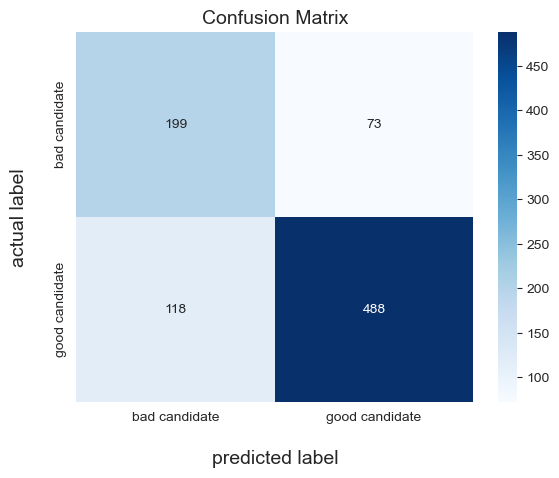

In [50]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

# Final Model

In [28]:
labels = ["bad candidate", "good candidate"]

In [29]:
X_train = pd.concat([X_train, X_eval], axis=0)
y_train = pd.concat([y_train, y_eval], axis=0)

In [30]:
# load features found by RFE during hyper-parameter tuning
with open('../models/random_forest/features_rfe.pkl', 'rb') as f:
    ftrs = pkl.load(f)

X_train = X_train.loc[:, X_train.columns.isin(ftrs)]
X_test = X_test.loc[:, X_test.columns.isin(ftrs)]

## Final Model

---

**Model:** RandomForest

**Parameters:** n_estimators: 450, max_depth: 5, class_weight: balanced

*The final model has been chosen based on the best weighted F1-score, Precision and Recall on the evaluation sample. Also, the degree of overfittng (or underfitting) has been taken into consideration.*

In [31]:
clf = RandomForestClassifier(
    n_estimators=450,
    max_depth=5,
    class_weight= 'balanced',
    random_state=42
)

clf.fit(X_train, np.ravel(y_train))

y_train_pred, y_train_pred_proba = clf.predict(X_train), clf.predict_proba(X_train)
y_test_pred, y_test_pred_proba = clf.predict(X_test), clf.predict_proba(X_test)

## Metrics

---

**Conclusion:** 
- The model doesn't overfit.
- The model is certain when it encounters good candidates (88% Precision, 83% Recall), however, it isn't confident when identifing bad candidates (62% Precision, 71% Recall). 

In [32]:
print(f"Train:\n{classification_report(y_train, y_train_pred, target_names=labels)}")
print(f"Test:\n{classification_report(y_test, y_test_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.63      0.71      0.67      1343
good candidate       0.88      0.82      0.85      3266

      accuracy                           0.79      4609
     macro avg       0.75      0.77      0.76      4609
  weighted avg       0.80      0.79      0.80      4609

Test:
                precision    recall  f1-score   support

 bad candidate       0.62      0.71      0.66       563
good candidate       0.88      0.83      0.85      1416

      accuracy                           0.80      1979
     macro avg       0.75      0.77      0.76      1979
  weighted avg       0.80      0.80      0.80      1979



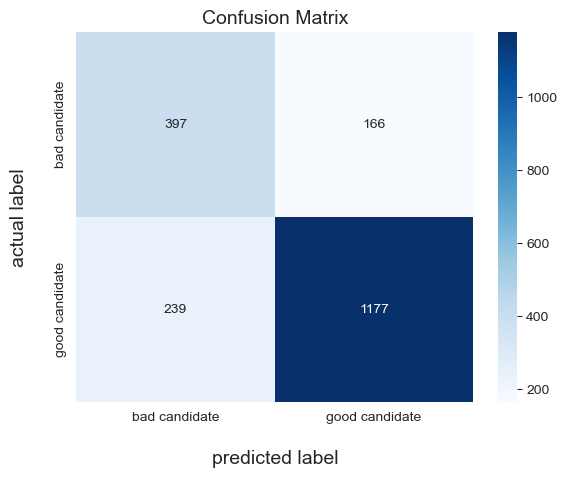

In [33]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## Model Analysis

We define clusters (groups) based on important variables for which we need to provide "accurate" prediction (derived by business needs). These clusters (groups) are based on: 
- principal loan amount
- loan interest rate
- RFM customer segments
- default rate
- existing v. new applicants 

The analysis is focused on the most important task, that being the prediction of bad loan candidates.

For those cluster, we observe the following:
- The model mainly mispredicts for medium to large loan amounts.
- The model mainly mispredicts for medium to large loan interest rates.
- Inability to bridge the Champions, Big Spenders and Promising users' purchasing behavior with their repayment behavior.
- Weakness to model repayment behavioral mostly for users with medium to large default rates.
- Great uncertainty when modeling behavior of new applicants.

In [34]:
# temp dataframe with test set (1) features, (2) ground truth and (3) prediction
temp_data_test = pd.concat([X_test, y_test], axis=1)
temp_data_test["prediction"] = y_test_pred.tolist()

# aux column marking correct/incorrect predictions
temp_data_test["correct"] = temp_data_test["prediction"] == temp_data_test["loan_quality"]
temp_data_test["correct"] = temp_data_test["correct"].replace({True: "correct", False: "incorrect"})

temp_data_test = temp_data_test[temp_data_test["loan_quality"] == 0]

In [35]:
# reverse one-hot encoding
rfm_segments = ["segment_Big Spenders", "segment_Champions", "segment_Inactive", "segment_Promising", "segment_Recent"]
temp_data_test["rfm_segments"] = pd.from_dummies(temp_data_test[rfm_segments])
temp_data_test["rfm_segments"] = temp_data_test["rfm_segments"].replace({
    "segment_Big Spenders": "Big Spenders", 
    "segment_Champions": "Champions",
    "segment_Inactive": "Inactive", 
    "segment_Promising": "Promising", 
    "segment_Recent": "Recent"
})

# calculate the percentage of correct/incorrect instances per RFM segment
df = temp_data_test.groupby(["rfm_segments"], as_index=False)["correct"].value_counts()
aux = df.groupby("rfm_segments", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["rfm_segments"].unique():
    df.loc[df["rfm_segments"] == i, "pct"] = df[df["rfm_segments"] == i]["count"].values / aux[aux["rfm_segments"] == i]["count"].values

fig = px.bar(
    df, 
    y='rfm_segments', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_purple"], colors["dark_blue"]]
)

fig.update_layout(
    title_text="<b>Inability to bridge the Champions, Big Spenders and Promising users'<br>purchasing behavior with their repayment behavior<b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of test bad loans',
    yaxis_title_text=None,
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=["Inactive", "Recent", "Promising", "Big Spenders", "Champions"]
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\1160949556.py:17: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.54545455 0.45454545]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



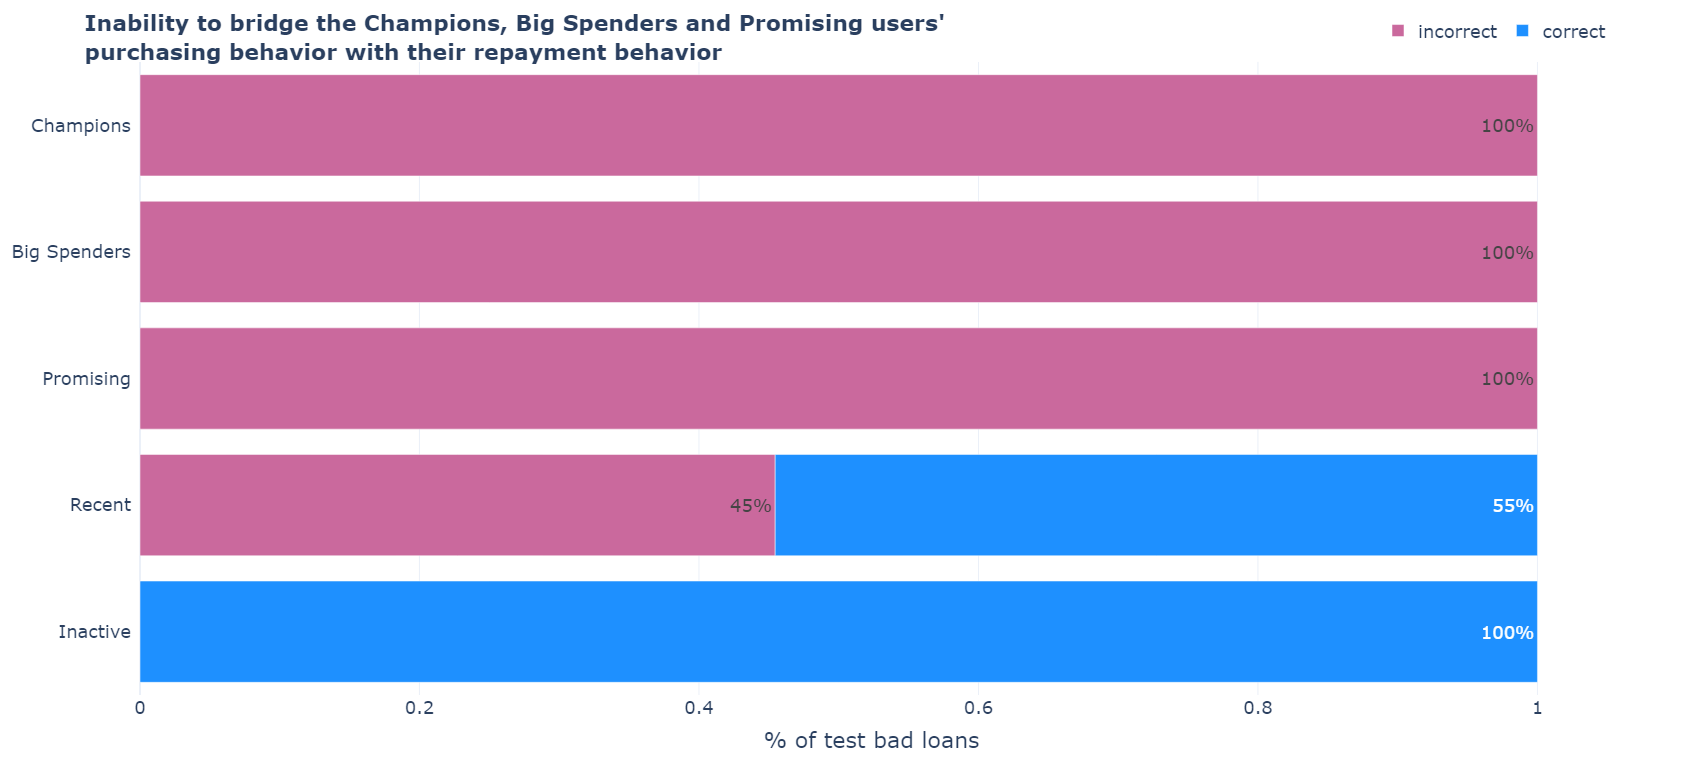

In [36]:
# reverse label encoding
temp_data_test["interest_rate_cat"] = temp_data_test["interest_rate_cat"].replace({
    1: "small", 
    2: "medium",
    3: "large", 
})

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["interest_rate_cat"], as_index=False)["correct"].value_counts()
aux = df.groupby("interest_rate_cat", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["interest_rate_cat"].unique():
    df.loc[df["interest_rate_cat"] == i, "pct"] = df[df["interest_rate_cat"] == i]["count"].values / aux[aux["interest_rate_cat"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='interest_rate_cat', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model mainly mispredicts for medium to large loan interest rates<b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of test bad loans',
    yaxis_title_text="intereset rate (%)",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\3979293147.py:13: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.76119403 0.23880597]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



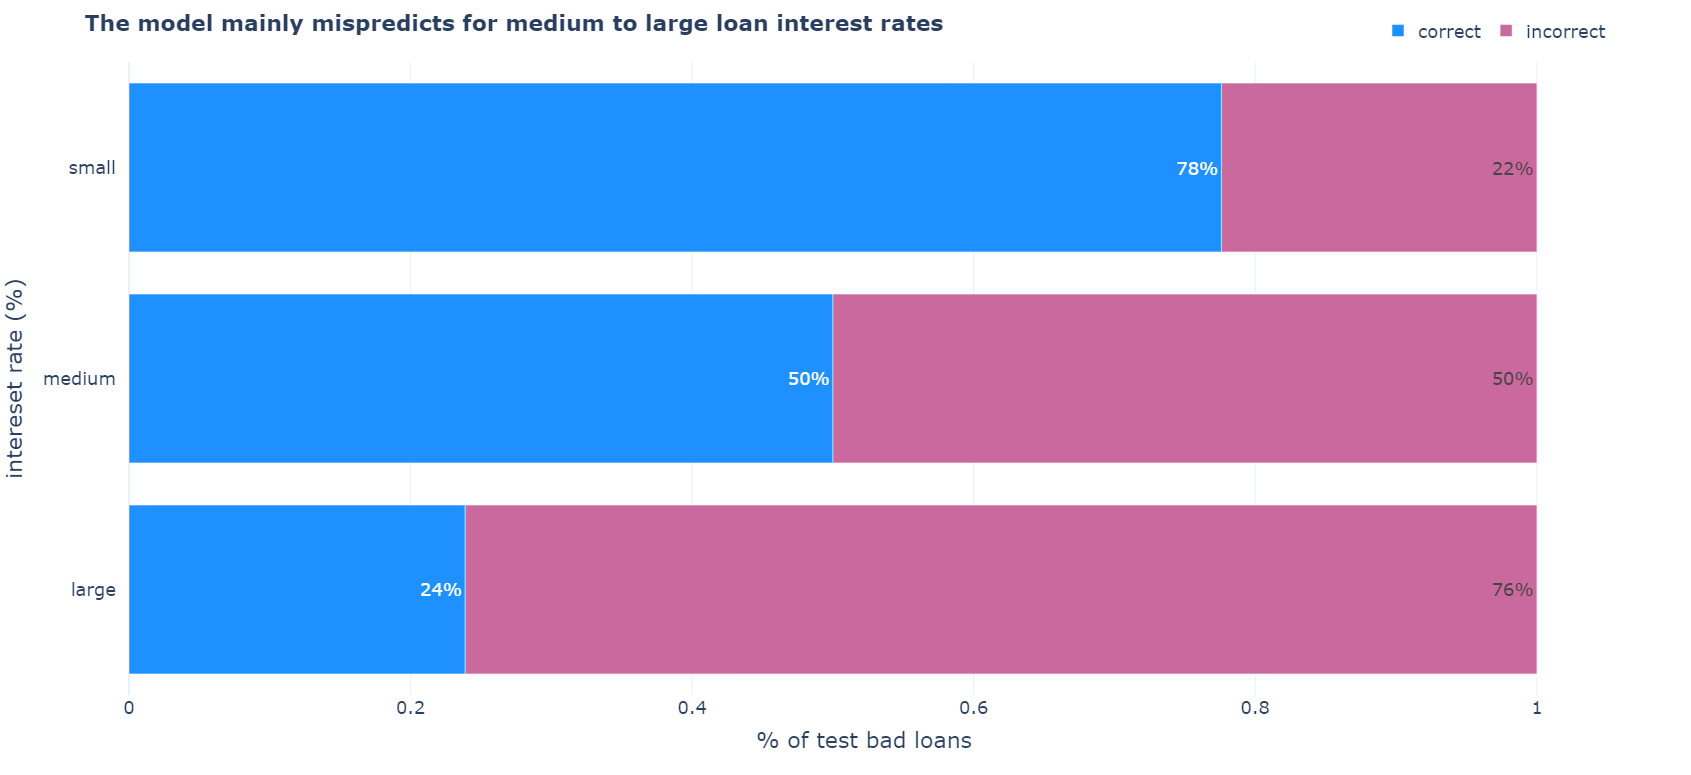

In [37]:
# reverse label encoding
temp_data_test["principal_amount_cat"] = temp_data_test["principal_amount_cat"].replace({
    1: "small", 
    2: "medium",
    3: "large", 
})

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["principal_amount_cat"], as_index=False)["correct"].value_counts()
aux = df.groupby("principal_amount_cat", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["principal_amount_cat"].unique():
    df.loc[df["principal_amount_cat"] == i, "pct"] = df[df["principal_amount_cat"] == i]["count"].values / aux[aux["principal_amount_cat"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='principal_amount_cat', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model mainly mispredicts for medium to large loan amounts</b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of test bad loans',
    yaxis_title_text="principal loan amount (R$)",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\1824184710.py:13: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.70172084 0.29827916]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



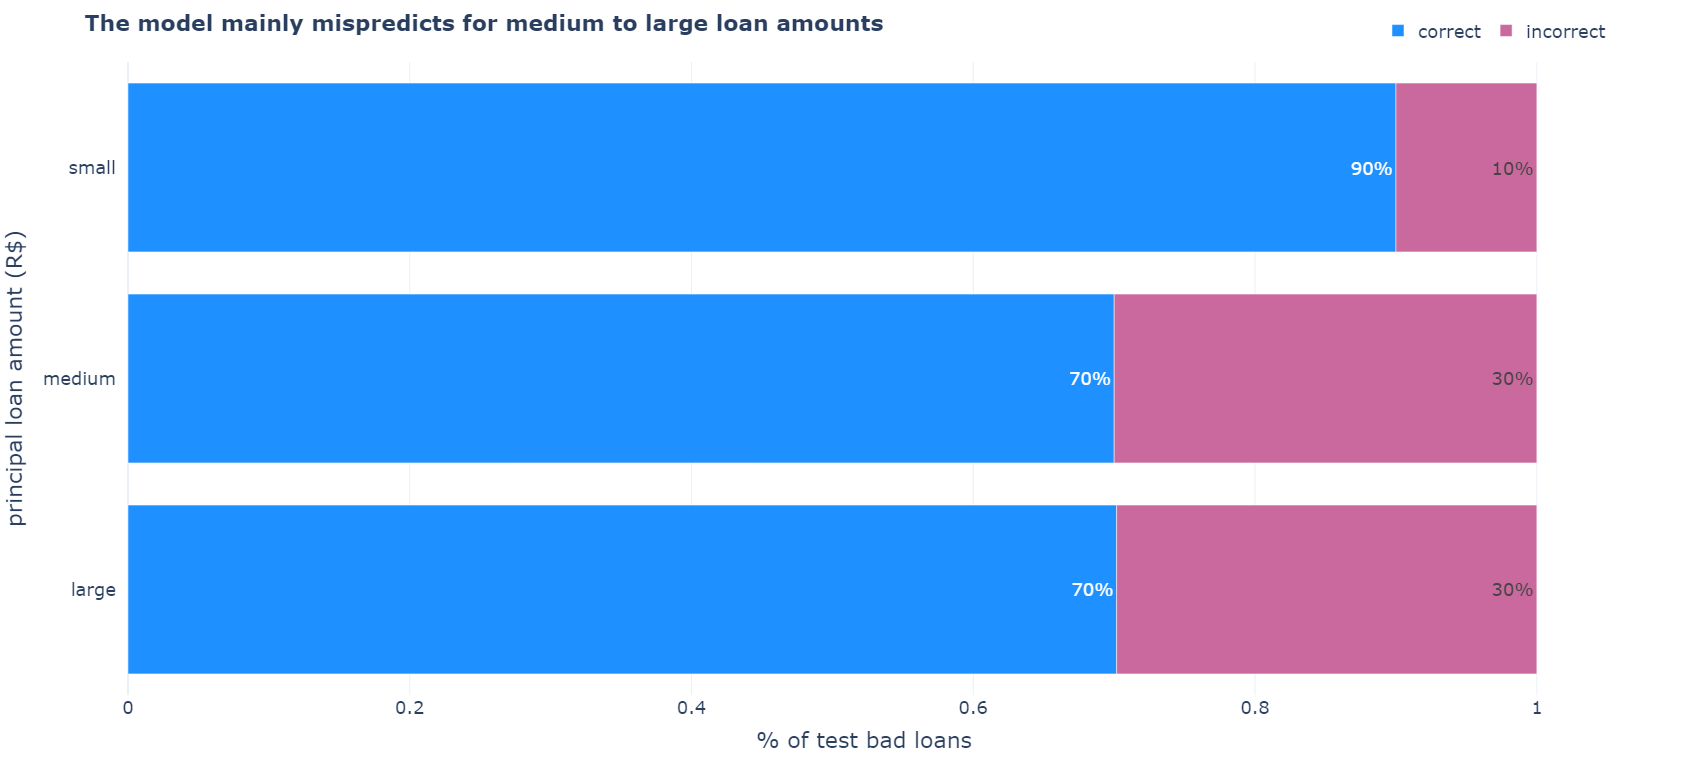

In [38]:
temp_data_test.loc[temp_data_test["user_avg_rate_default"] <= .05, "rate_default_cat"] = "small"
temp_data_test.loc[temp_data_test["user_avg_rate_default"].between(.05, .1, inclusive='right'), "rate_default_cat"] = "medium"
temp_data_test.loc[temp_data_test["user_avg_rate_default"] > .1, "rate_default_cat"] = "large"

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["rate_default_cat"], as_index=False)["correct"].value_counts()
aux = df.groupby("rate_default_cat", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["rate_default_cat"].unique():
    df.loc[df["rate_default_cat"] == i, "pct"] = df[df["rate_default_cat"] == i]["count"].values / aux[aux["rate_default_cat"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='rate_default_cat', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>Weakness to model repayment behavioral mostly for users with medium to large default rates<b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of test bad loans',
    yaxis_title_text="default rate (%)",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\2340966245.py:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.53846154 0.46153846]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



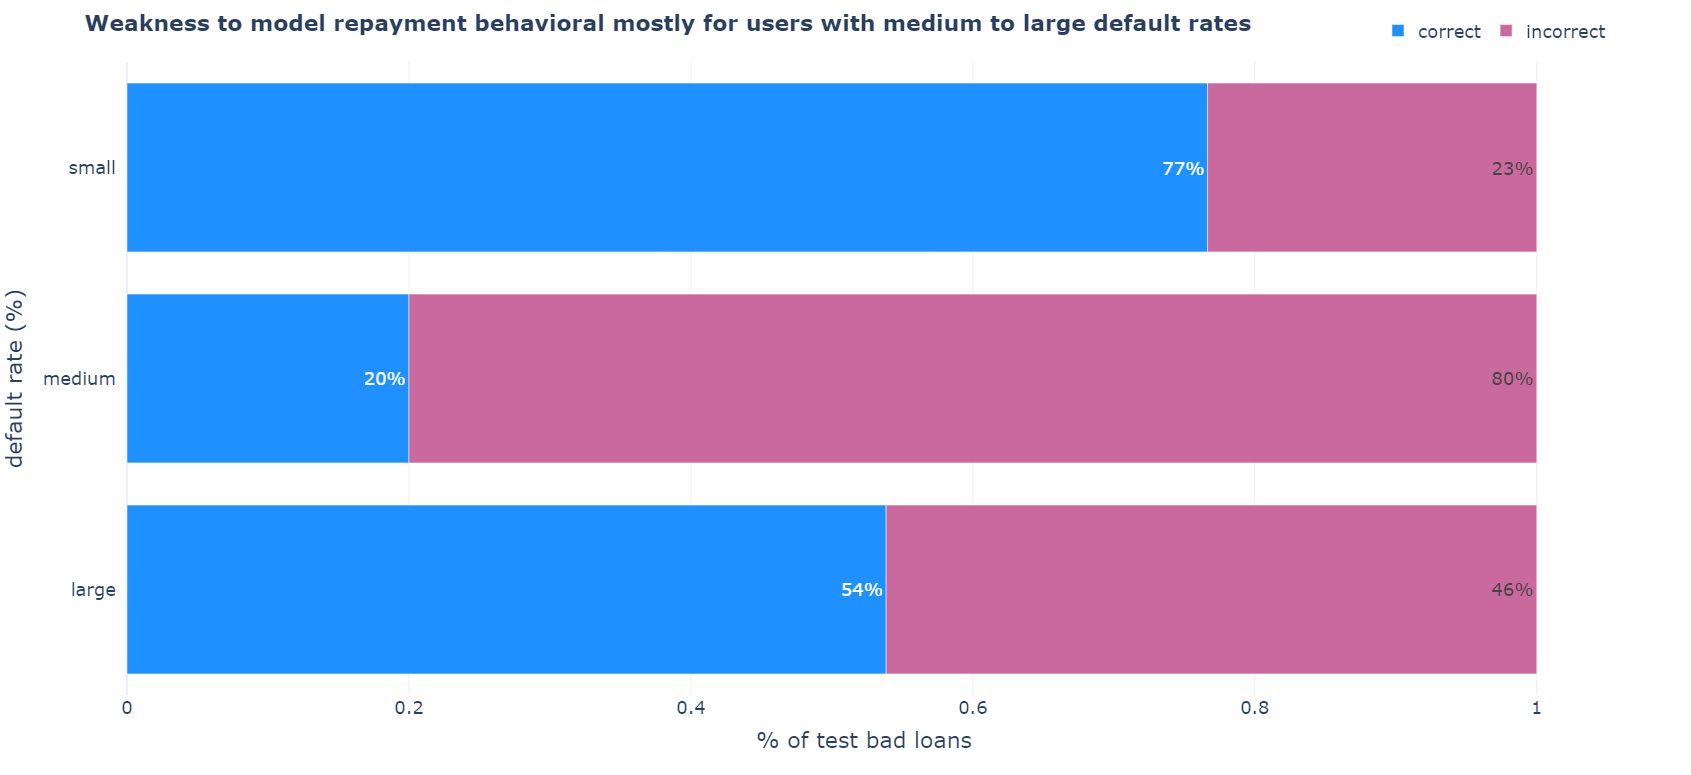

In [39]:
temp_data_test["applicant_history"] = "old applicant"
temp_data_test.loc[temp_data_test["user_num_loans"] == 0, "applicant_history"] = "new applicant"

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["applicant_history"], as_index=False)["correct"].value_counts()
aux = df.groupby("applicant_history", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["applicant_history"].unique():
    df.loc[df["applicant_history"] == i, "pct"] = df[df["applicant_history"] == i]["count"].values / aux[aux["applicant_history"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='applicant_history', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>Great uncertainty to model behavior of new applicants<b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of test bad loans',
    yaxis_title_text=None,
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

C:\Users\lampr\AppData\Local\Temp\ipykernel_4492\263791540.py:9: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.86216216 0.13783784]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



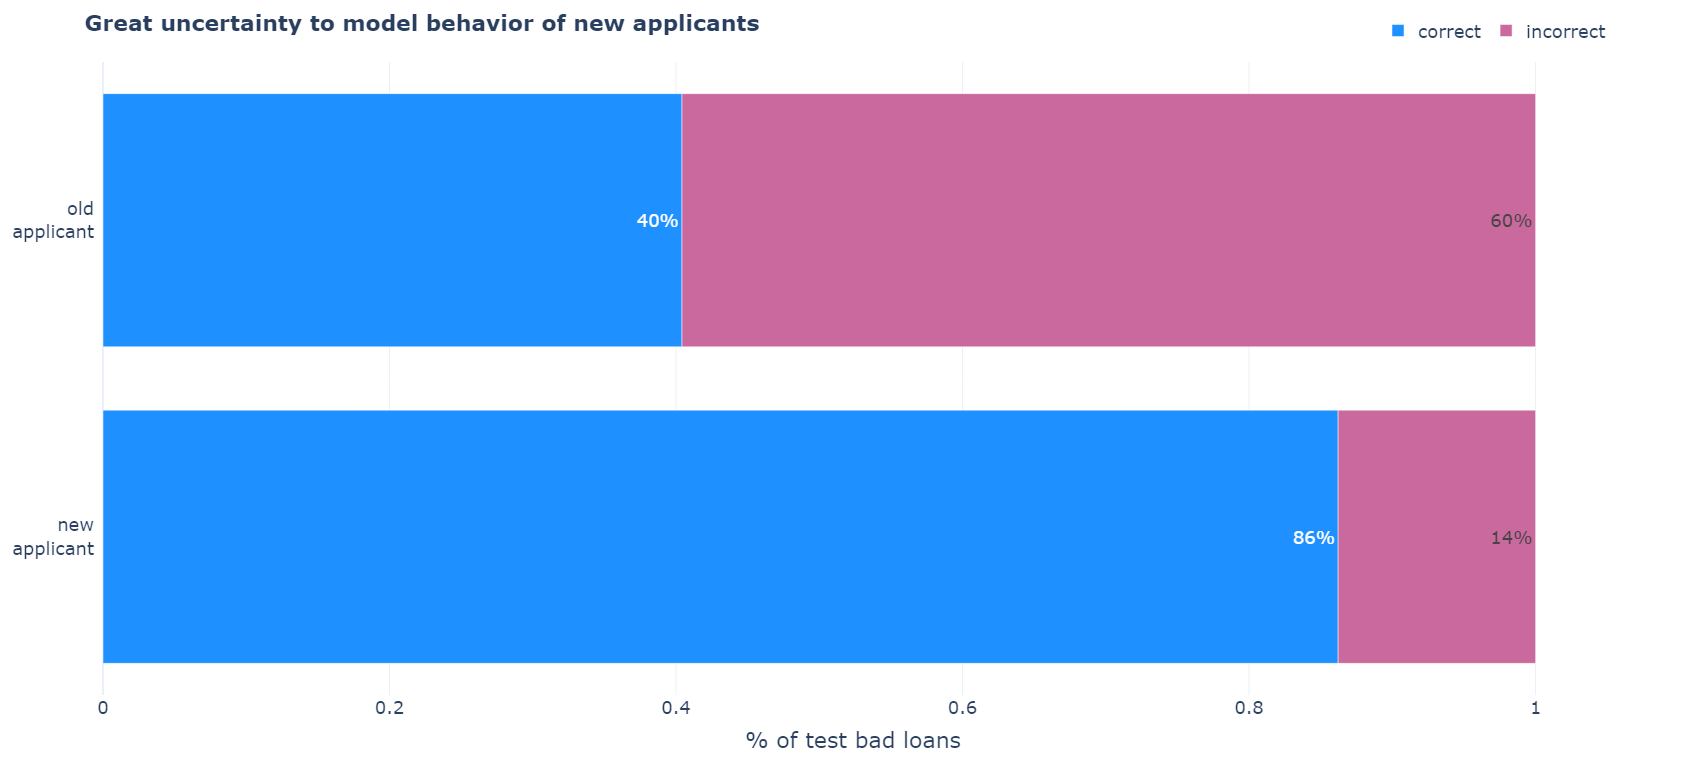

## Feature Importance

In [41]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)

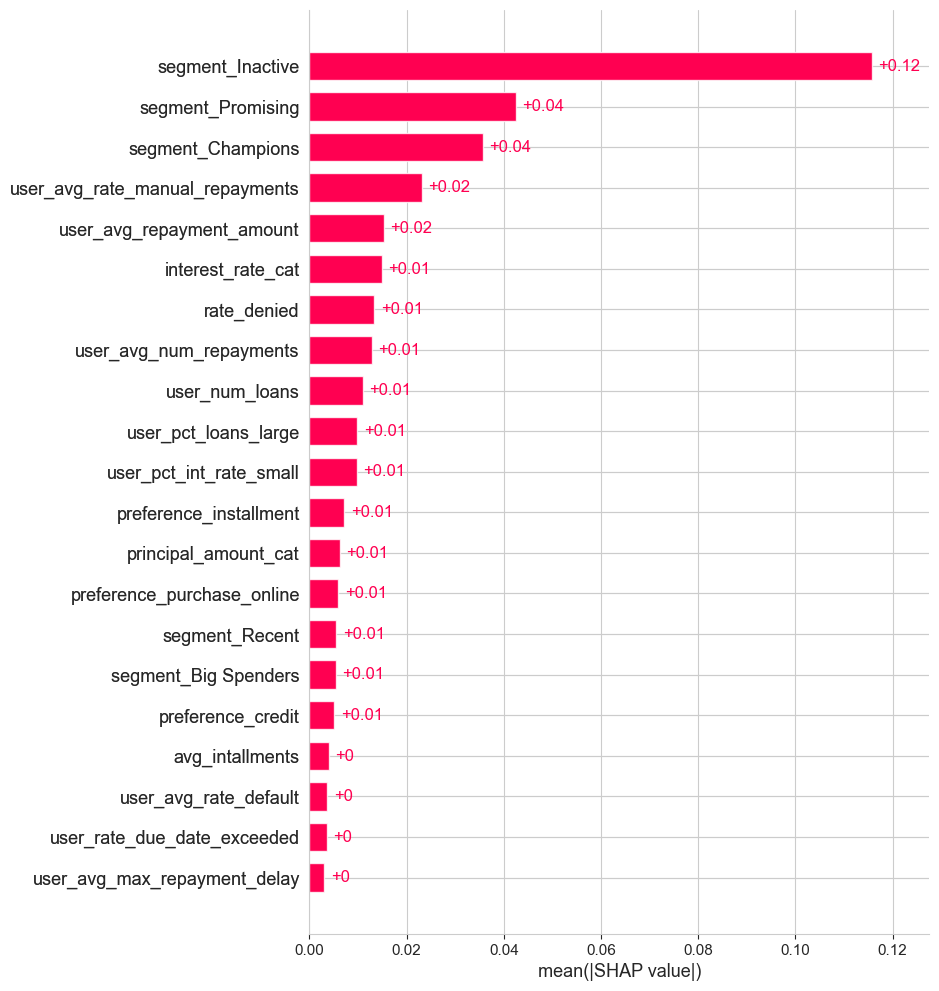

In [66]:
shap.plots.bar(shap_values[:,:,0], max_display=25)

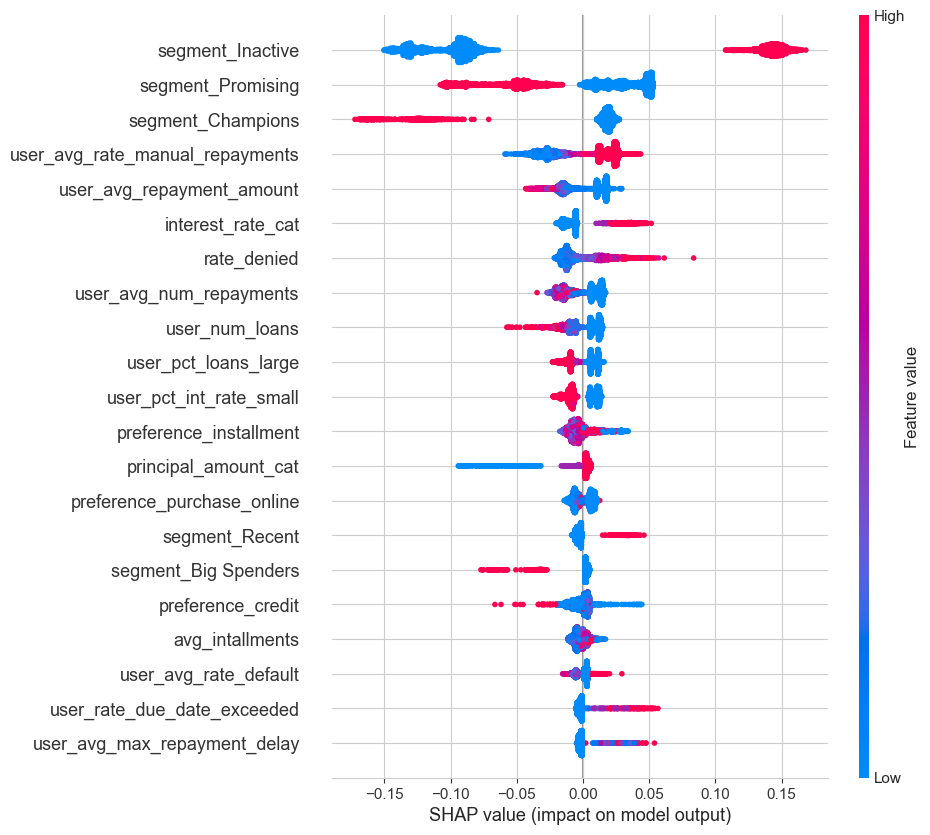

In [67]:
shap.plots.beeswarm(shap_values[:,:,0], max_display=25)